## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

1. Download and import Load the smoking dataset from: [https://data.princeton.edu/wws509/datasets/#smoking](https://data.princeton.edu/wws509/datasets/#smoking). Then perform a train-test split on the data;


In [971]:
%reset -f
import numpy as np
import pandas as pd

import pyro
import pyro.distributions as dist
import pyro.optim as optim
pyro.clear_param_store()

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

import torch
import torch.distributions.constraints as constraints

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

pyro.set_rng_seed(42)

In [973]:
# reading data
data = pd.read_csv("https://data.princeton.edu/wws509/datasets/smoking.dat",sep="\s+")
data.columns = ["Age_Group","Smoking_Status","Population","Deaths"]
data.head()

,Age_Group,Smoking_Status,Population,Deaths
1,40-44,no,656,18
2,45-59,no,359,22
3,50-54,no,249,19
4,55-59,no,632,55
5,60-64,no,1067,117


I used one hot encoding for categorical variables because there is no order in categorical variables and using label encoder may manipulate the result of regression analysis.

In [974]:
# use one hot encoding for categorical variables
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1 to 36
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Population                     36 non-null     int64
 1   Deaths                         36 non-null     int64
 2   Age_Group_40-44                36 non-null     uint8
 3   Age_Group_45-59                36 non-null     uint8
 4   Age_Group_50-54                36 non-null     uint8
 5   Age_Group_55-59                36 non-null     uint8
 6   Age_Group_60-64                36 non-null     uint8
 7   Age_Group_65-69                36 non-null     uint8
 8   Age_Group_70-74                36 non-null     uint8
 9   Age_Group_75-79                36 non-null     uint8
 10  Age_Group_80+                  36 non-null     uint8
 11  Smoking_Status_cigarPipeOnly   36 non-null     uint8
 12  Smoking_Status_cigarretteOnly  36 non-null     uint8
 13  Smoking_Status_cigarre

In [975]:
# scale the population since it dominates the predictors  * X
scaler = MinMaxScaler()
data["Population"] = scaler.fit_transform(pd.DataFrame(data["Population"]))

Now we perform a train-test split on the data:
- **train data** - 80% of the observations will be used to perfom inference on our model
- **test data** - the remaining 20% will be used for testing the correctness of posterior predictions 

In [976]:
deaths = torch.tensor(data["Deaths"].values, dtype=torch.float)
predictors = torch.stack([torch.tensor(data[column].values,dtype=torch.float) 
                            for column in data.columns if column != "Deaths"],1)

In [977]:
X_train, X_test, y_train, y_test = train_test_split(predictors, deaths, test_size=0.20, 
                                                    random_state=42,shuffle=True)

print("X_train.shape =", X_train.shape,"\ny_train.shape =", y_train.shape)
print("\nX_test.shape =", X_test.shape,"\ny_test.shape =", y_test.shape)

X_train.shape = torch.Size([28, 14]) 
y_train.shape = torch.Size([28])

X_test.shape = torch.Size([8, 14]) 
y_test.shape = torch.Size([8])


2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables;

The target variable in our model is the number of deaths and we wish to infer the parameters corresponding to the following predictors

\begin{align*}
\text{Deaths}=\text{exp}(w_0.\text{Age_Group}+w_1.\text{Smoking_Status}+w_2.\text{Population}+b) + \epsilon
\end{align*}

We set a normal prior on $w$, a Log-Normal on the bias term $b$ and a uniformly distributed std for the gaussian noise on $\hat{y}$

\begin{align*}
w&\sim\mathcal{N}(0,1)\\
b&\sim\text{LogNormal}(0,1)\\
\hat{\mu}&= \text{exp}(w x+ b) \\
y &\sim \text{Poisson}(\hat{\mu}).
\end{align*}

Then we define the family of posterior distributions, by setting a Gamma distribution on $w$ and a Log-Normal on $b$, and run SVI inference on $(x,y)$ data.

Notice the prior distribution on the bias term makes this regression problem analytically intractable.

In [978]:
pyro.clear_param_store()
def death_model(predictors, deaths):
    
    n_observations, n_predictors = predictors.shape
    
    # sample weights
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), 
                                        torch.ones(n_predictors)))
    b = pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))
    
    mu_hat = torch.exp((w*predictors).sum(dim=1) + b)
    
    # condition on the observations
    with pyro.plate("deaths", len(deaths)):
        pyro.sample("obs", dist.Poisson(mu_hat), obs=deaths)
        
def death_guide(predictors, deaths=None):
    
    n_observations, n_predictors = predictors.shape
        
    w_loc = pyro.param("w_loc", torch.rand(n_predictors), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), 
                         constraint=constraints.positive)
    
    w = pyro.sample("w", dist.Gamma(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)
    
    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))
    

# auto guide most of the time gives better result but for learning purpose
# manually defined one will be used, there is no big difference
# 321-298 improvement

#smokeguide = pyro.infer.autoguide.AutoMultivariateNormal(death_model)
    
death_svi = SVI(model=death_model, guide=death_guide, 
              optim=optim.ClippedAdam({'lr' : 0.01}), 
              loss=Trace_ELBO())

for step in range(2000):
    loss = death_svi.step(X_train, y_train)/len(X_train)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 217895.35066302758
Step 100 : loss = 3383911439229.7007
Step 200 : loss = 1411479.4769667494
Step 300 : loss = 1118.7773887770516
Step 400 : loss = 37302.596219633306
Step 500 : loss = 90550.50495592186
Step 600 : loss = 3510677.8439829606
Step 700 : loss = 108318219136.47739
Step 800 : loss = 623256735.4375366
Step 900 : loss = 430.7892849275044
Step 1000 : loss = 11438910790531.85
Step 1100 : loss = 814.2677540949413
Step 1200 : loss = 1862.99787238666
Step 1300 : loss = 1565471.531037603
Step 1400 : loss = 1294.398164476667
Step 1500 : loss = 21855.950535433632
Step 1600 : loss = 1752.1302978651863
Step 1700 : loss = 4.0800620540319803e+24
Step 1800 : loss = 2177726.2398586953
Step 1900 : loss = 189714.59514348846


In [979]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 0.11593594
w_1 = 0.10179897
w_2 = 0.12004398
w_3 = 0.09836756
w_4 = 0.18008943
w_5 = 0.13515201
w_6 = 0.10061953
w_7 = 0.09885138
w_8 = 0.10401431
w_9 = 0.12987916
w_10 = 0.80996382
w_11 = 1.07109785
w_12 = 1.51700020
w_13 = 0.91584867
b = -11.31038952


**Posterior predictive distribution**

We can use the `Predictive` utility class, corresponding to the posterior predictive distribution, to evaluate our model on test data. Here we compute some summary statistics (mean, std and qualtiles) on $100$ samples from the posterior predictive:

In [980]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=death_model, guide=death_guide, num_samples=100,
                        return_sites=("w","b"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(X_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

        mean       std            5%           50%        95%
0   0.000018  0.000040  1.220487e-15  5.197465e-07   0.000088
1   0.000007  0.000021  2.174336e-17  5.698389e-08   0.000033
2   0.000010  0.000027  1.863642e-15  4.077608e-07   0.000036
3   0.000011  0.000031  2.803844e-16  1.145644e-07   0.000076
4   0.006052  0.011038  1.042071e-08  9.302986e-04   0.025521
5   0.001546  0.004166  1.535496e-13  2.576341e-05   0.008286
6   0.000063  0.000256  2.915269e-15  3.726441e-07   0.000314
7   0.000036  0.000118  2.506584e-16  2.196494e-07   0.000169
8   0.000092  0.000224  3.132012e-15  1.266955e-06   0.000586
9   0.000550  0.001281  1.462001e-13  2.881433e-05   0.003084
10  5.998237  6.561357  4.735391e-01  3.803491e+00  19.403400
11  6.661482  6.679515  5.774164e-01  4.415251e+00  19.460052
12  8.580370  6.622905  7.702938e-01  6.812704e+00  21.563299
13  6.609722  7.496481  2.560628e-01  4.449547e+00  20.437329

Sampled parameter = b

       mean       std  


3. Evaluate the regression fit on test data using MAE and MSE error metrics.

The most known metrics for comparing different regression models are the **Mean Absolute Error** (MAE)

$$\frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|$$

and the **Mean Squared Error** (MSE)

$$\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2,$$

where $n$ is the number of observations, $y$ are the true values `y_test` and $\hat{y}$ are the predicted values `y_pred`.

In [981]:
# compute predictions using the inferred paramters
y_pred = torch.exp((inferred_w * X_test).sum(1)) + inferred_b

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())

MAE = 321.85369873046875
MSE = 168857.0625


## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

To be able to use logistic regression for multiclass problem, I found two strategies. Belove you can find the results of them.

* First one is **converting Bernoulli to Categorical distribution (given hint)** and inferring w,b for each classes. In this method maximum probability is chosen from the result of $e^{w.x + b}$ matrix. 

Also I tried to use softmax function instead of sigmoid but most probably because of mistake in one of the step I got wrong results. That is why I kept using sigmoid function.


1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

In [1009]:
%reset -f
import numpy as np
import pandas as pd

import pyro
import pyro.distributions as dist
import pyro.optim as optim
pyro.clear_param_store()

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer import autoguide

import torch
import torch.distributions.constraints as constraints

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

pyro.set_rng_seed(42)

In [1010]:
# loading dataset
iris = datasets.load_iris()

# dataset normalization and OneHotEncoding
iris_data = (iris.data - np.min(iris.data))/(np.max(iris.data)-np.min(iris.data))

In [1011]:
iris_data = torch.tensor(iris_data,dtype=torch.double)
iris_target = torch.tensor(iris.target,dtype=torch.double)

X_train, X_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.20, 
                                                    random_state=42)

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

Here I used many distributions for guide and `Laplace` gave the best result in terms of overall accuracy and the accuracy among the classes

Step 0 : loss = 1.1749493515175933
Step 1000 : loss = 1.205179748685519
Step 2000 : loss = 1.1422184678699614
Step 3000 : loss = 1.1131413117644433
Step 4000 : loss = 1.1625843565338694
Step 5000 : loss = 1.1121754668262114
Step 6000 : loss = 1.0413399957427572
Step 7000 : loss = 1.081022145199147
Step 8000 : loss = 1.1231808751010297
Step 9000 : loss = 1.0551129989547


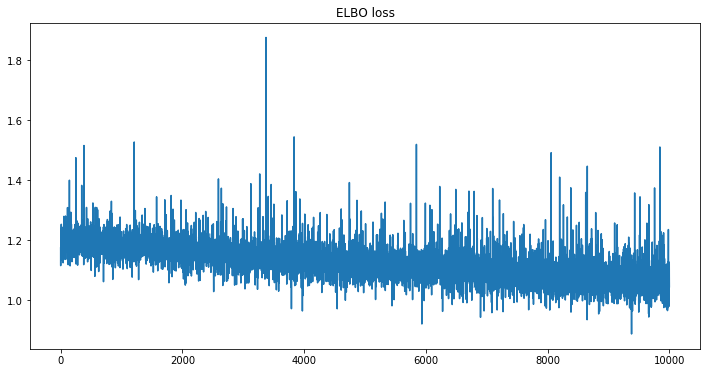

In [1012]:
# model and guide functions
def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    # Here 4x3 w matrix will be learnt
    w_zero = pyro.sample("w_zero", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_zero = pyro.sample("b_zero", dist.Normal(0.,1.))
    
    w_one = pyro.sample("w_one", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_one = pyro.sample("b_one", dist.Normal(0.,1.))
    
    w_two = pyro.sample("w_two", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_two = pyro.sample("b_two", dist.Normal(0.,1.))
    
    # non-linearity
    yhat_zero = torch.sigmoid((w_zero*x).sum(dim=1) + b_zero)
    yhat_one = torch.sigmoid((w_one*x).sum(dim=1) + b_one)
    yhat_two = torch.sigmoid((w_two*x).sum(dim=1) + b_two)
    
    yhat = torch.stack((yhat_zero,yhat_one, yhat_two),dim=1)
    
    with pyro.plate("data", n_observations):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Categorical(yhat), obs=y)
               
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_loc_zero = pyro.param("w_loc_zero", torch.rand(n_predictors))
    w_scale_zero = pyro.param("w_scale_zero", torch.rand(n_predictors), constraint=constraints.positive)
    w_zero = pyro.sample("w_zero", dist.Laplace(w_loc_zero, w_scale_zero))
    
    b_loc_zero = pyro.param("b_loc_zero", torch.rand(1))
    b_scale_zero = pyro.param("b_scale_zero", torch.rand(1), constraint=constraints.positive)
    b_zero = pyro.sample("b_zero", dist.Normal(b_loc_zero, b_scale_zero))
    
    w_loc_one = pyro.param("w_loc_one", torch.rand(n_predictors))
    w_scale_one = pyro.param("w_scale_one", torch.rand(n_predictors), constraint=constraints.positive)
    w_one = pyro.sample("w_one", dist.Laplace(w_loc_one, w_scale_one))
    
    b_loc_one = pyro.param("b_loc_one", torch.rand(1))
    b_scale_one = pyro.param("b_scale_one", torch.rand(1), constraint=constraints.positive)
    b_one = pyro.sample("b_one", dist.Normal(b_loc_one, b_scale_one))
    
    w_loc_two = pyro.param("w_loc_two", torch.rand(n_predictors))
    w_scale_two = pyro.param("w_scale_two", torch.rand(n_predictors), constraint=constraints.positive)
    w_two = pyro.sample("w_two", dist.Laplace(w_loc_two, w_scale_two))
    
    b_loc_two = pyro.param("b_loc_two", torch.rand(1))
    b_scale_two = pyro.param("b_scale_two", torch.rand(1), constraint=constraints.positive)
    b_two = pyro.sample("b_two", dist.Normal(b_loc_two, b_scale_two))

#auto_guide_log = pyro.infer.autoguide.AutoDelta(log_reg_model)


log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
          optim=optim.ClippedAdam({'lr' : 0.0002}), 
          loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(X_train, y_train)/len(X_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(losses)
ax.set_title("ELBO loss");

In [1013]:
# getting the inferred parameters for manual 
param = list(pyro.get_param_store().keys())

w_zero = pyro.get_param_store()[param[0]]
w_one = pyro.get_param_store()[param[4]]
w_two = pyro.get_param_store()[param[8]]
b_zero = pyro.get_param_store()[param[2]]
b_one = pyro.get_param_store()[param[6]]
b_two = pyro.get_param_store()[param[10]]

In [1014]:
# prediction class which returns to output label as 0,1 or 2
# by choosing the max probability

def predict_class(x):
    out_zero = torch.sigmoid((w_zero * x).sum(dim=1) + b_zero)
    out_one = torch.sigmoid((w_one * x).sum(dim=1) + b_one)
    out_two = torch.sigmoid((w_two * x).sum(dim=1) + b_two)
    out = torch.stack((out_zero,out_one,out_two),dim=1)
    return torch.argmax(out,dim=1)

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

In [991]:
count_zero = 0
count_one = 0
count_two = 0
for i,j in zip(predict_class(X_test) , y_test):
    if j == 0 and i == 0:
        count_zero +=1
    elif j == 1 and i == 1:
        count_one += 1
    elif j == 2 and i == 2:
        count_two += 1

In [992]:
correct_predictions_zero = (count_zero / len(y_test[y_test == 0])) *100
correct_predictions_one = (count_one / len(y_test[y_test == 1])) *100
correct_predictions_two = (count_two / len(y_test[y_test == 2])) *100

correct_predictions_final = (predict_class(X_test) == y_test).sum().item()

print("Accuracy for class 0 {:.2f}".format(correct_predictions_zero),"%")
print("Accuracy for class 1 {:.2f}".format(correct_predictions_one),"%")
print("Accuracy for class 2 {:.2f}".format(correct_predictions_two),"%")

print(f"Overal test accuracy = {correct_predictions_final/len(X_test)*100:.2f}%")

Accuracy for class 0 100.00 %
Accuracy for class 1 100.00 %
Accuracy for class 2 81.82 %
Overal test accuracy = 93.33%


Here, label 2 is misclassified twice. It is normal because it is hard to classify label 1 and label 2. Overall accuracy and accuracy among the classes are good enough.

* Second idea is using, one vs all strategy to use logistic regression for multiclass problem. Here I trained 3 binary classifier and inferred different w and b. I compared the probabilities of three binary classifiers and choose the class which has the highest probability  

1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

In [993]:
%reset -f
import numpy as np
import pandas as pd

import pyro
import pyro.distributions as dist
import pyro.optim as optim
pyro.clear_param_store()

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer import autoguide

import torch
import torch.distributions.constraints as constraints

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

pyro.set_rng_seed(42)

In [994]:
# loading dataset
iris = datasets.load_iris()

In [996]:
# dataset normalization
iris_data = (iris.data - np.min(iris.data))/(np.max(iris.data)-np.min(iris.data))

# Each class will be 0 before vs rest will be 1 

# 0 vs rest dataset , just make 2 -> 1
zerovsrest = np.where((iris.target == 2),1,iris.target)
# 1 vs rest dataset , make 1 -> 0 and 0,2 -> 1
onevsrest = np.where((iris.target == 2),-1,iris.target)
onevsrest = np.where((onevsrest == 0),-1,onevsrest)
onevsrest = np.where((onevsrest == 1),0,onevsrest)
onevsrest = np.where((onevsrest == -1),1,onevsrest)

# 2 vs rest dataset, make 0,1 -> 1 and 2 -> 0
twovsrest = np.where((iris.target == 0),1,iris.target)
twovsrest = np.where((twovsrest == 2),0,twovsrest)

Above, I prepared the data set for each binary classifier.

In [997]:
iris_data = torch.tensor(iris_data,dtype=torch.double)
iris_target = torch.tensor(iris.target,dtype=torch.double)
zerovsrest = torch.tensor(zerovsrest,dtype=torch.double)
onevsrest = torch.tensor(onevsrest,dtype=torch.double)
twovsrest = torch.tensor(twovsrest,dtype=torch.double)

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

Here many distribution in model function and many auto guide were tested like first strategy and best ones chosen which is `LogNormal` for the model and `AutoLaplaceApproximation` for the auto guide.

In [998]:
# model and guide functions
def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    w = pyro.sample("w", dist.LogNormal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b = pyro.sample("b", dist.LogNormal(0.,1.))
    
    # non-linearity
    yhat = torch.sigmoid((w*x).sum(dim=1) + b)
    
    with pyro.plate("data", n_observations):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Bernoulli(yhat), obs=y)
        
        
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_loc = pyro.param("w_loc", torch.rand(n_predictors))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), 
                         constraint=constraints.positive)
    w = pyro.sample("w", dist.Normal(w_loc,w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), 
                         constraint=constraints.positive)
    b = pyro.sample("b", dist.Normal(b_loc,b_scale))
    
auto_guide_log = pyro.infer.autoguide.AutoLaplaceApproximation(log_reg_model)

In [999]:
def learn_infer_parameters(X_train ,y_train, auto = False):
    # delete previously inferred params from pyro.param_store()
    pyro.clear_param_store()
    
    log_reg_svi = SVI(model=log_reg_model, guide=auto_guide_log, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO()) 

    losses = []
    for step in range(10000):
        loss = log_reg_svi.step(X_train, y_train)/len(X_train)
        losses.append(loss)
        if step % 1000 == 0:
            print(f"Step {step} : loss = {loss}")
            
    if auto == True:
        
        param = list(pyro.get_param_store().keys())
        inferred = pyro.get_param_store()[param[0]]

        inferred_w = inferred[0:len(X_train[0,:])]
        inferred_b = inferred[len(X_train[0,:])]
        return inferred_w, inferred_b
    
    else:
        w = pyro.get_param_store()["w_loc"]
        b = pyro.get_param_store()["b_loc"]

        return w,b


def return_prob(w,b,x):
    out = torch.sigmoid((w * x).sum(dim=1) + b)
    return out

In [1000]:
# Splittig the original dataset
X_train, X_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.20, 
                                                    random_state=42)


# split all the dataset , 0->0  vs 1,2 -> 1
X_train_zero, X_test_zero, y_train_zero, y_test_zero = train_test_split(iris_data, zerovsrest, test_size=0.20, 
                                                    random_state=42)
w_zero , b_zero = learn_infer_parameters(X_train_zero, y_train_zero,auto=True)

out_zero = return_prob(w_zero, b_zero, X_test_zero)
print("First binary classifier is trained and inferred parameters are stored")

# split all the dataset, 1 -> 0 , 0,2 ->1
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(iris_data, onevsrest, test_size=0.20, 
                                                    random_state=42)

w_one , b_one = learn_infer_parameters(X_train_one, y_train_one,auto=True)

out_one = return_prob(w_one, b_one, X_test_one)
print("Second binary classifier is trained and inferred parameters are stored")

# split all the dataset 2->0 , 0,1 -> 1
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(iris_data, twovsrest, test_size=0.20, 
                                                    random_state=42)

w_two , b_two = learn_infer_parameters(X_train_two, y_train_two,auto=True)

out_two = return_prob(w_two, b_two, X_test_two)
print("Third binary classifier is trained and inferred parameters are stored")

Step 0 : loss = 0.9493689349039591
Step 1000 : loss = 0.8254076303922392
Step 2000 : loss = 0.7377631665897586
Step 3000 : loss = 0.6744407804802958
Step 4000 : loss = 0.6306662108382127
Step 5000 : loss = 0.5986701638021614
Step 6000 : loss = 0.5727129290434849
Step 7000 : loss = 0.551088322621781
Step 8000 : loss = 0.5332139734822869
Step 9000 : loss = 0.5193220599354917
First binary classifier is trained and inferred parameters are stored
Step 0 : loss = 1.073270269521865
Step 1000 : loss = 0.9734208012655652
Step 2000 : loss = 0.9031427923782857
Step 3000 : loss = 0.8526560142032932
Step 4000 : loss = 0.8160845029062179
Step 5000 : loss = 0.78934484221927
Step 6000 : loss = 0.769598794583281
Step 7000 : loss = 0.7560054581324416
Step 8000 : loss = 0.7463864005831833
Step 9000 : loss = 0.7389349458949094
Second binary classifier is trained and inferred parameters are stored
Step 0 : loss = 0.7856684751848356
Step 1000 : loss = 0.7710108097064106
Step 2000 : loss = 0.7610639386180128

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

In [1001]:
# here is the predictions basically, each base class labeled as zero so I am choosing the highest probability for 
# these labels
out_final = torch.stack((out_zero,out_one,out_two),dim=1)
predictions = torch.argmin(out_final,dim=1)

In [1004]:
for i,j in zip(predictions,y_test):
    if i != j:
        print(i,j)

tensor(2, grad_fn=<SelectBackward>) tensor(1., dtype=torch.float64)


In [1002]:
count_zero = 0
count_one = 0
count_two = 0
for i,j in zip(predictions , y_test):
    if j == 0 and i == 0:
        count_zero +=1
    elif j == 1 and i == 1:
        count_one += 1
    elif j == 2 and i == 2:
        count_two += 1

In [1003]:
correct_predictions_zero = (count_zero / len(y_test[y_test == 0])) *100
correct_predictions_one = (count_one / len(y_test[y_test == 1])) *100
correct_predictions_two = (count_two / len(y_test[y_test == 2])) *100

correct_predictions_final = (predictions == y_test).sum().item()

print("Accuracy for class 0 {:.2f}".format(correct_predictions_zero),"%")
print("Accuracy for class 1 {:.2f}".format(correct_predictions_one),"%")
print("Accuracy for class 2 {:.2f}".format(correct_predictions_two),"%")

print(f"Overal test accuracy = {correct_predictions_final/len(X_test)*100:.2f}%")

Accuracy for class 0 100.00 %
Accuracy for class 1 88.89 %
Accuracy for class 2 100.00 %
Overal test accuracy = 96.67%


Here there is only one misclassification and overall accuracy is good and the accuracy among the classes are good as well. Having misclassification is normal since it is hard to classify 1 and 2. Indeed having only one classification error is satisfying.